In [2]:
import torch
from torchvision import datasets, transforms

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load STL10 dataset
train_dataset = datasets.STL10(root='../data', split='train+unlabeled', transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU
    print('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")   # Use Apple's Metal (for M1/M2 Macs)
    print('mps')
else:
    device = torch.device("cpu") 
    print('cpu')

cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10  # This automatically handles the dataset splitting in memory
from torchvision.datasets import STL10
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet18 = models.resnet18(weights=None)  
        
        # Convert generator to list before slicing
        self.encoder = nn.Sequential(*list(resnet18.children())[:-2])
        
    def forward(self, x):
        return self.encoder(x)
    
# class ChannelWiseFC(nn.Module):
#     def __init__(self, in_channels):
#         super(ChannelWiseFC, self).__init__()
#         self.fc = nn.Conv2d(in_channels, in_channels, kernel_size=1)
    
#     def forward(self, x):
#         return self.fc(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: 256, 6, 6
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: 128, 12, 12
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 64, 24, 24
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # Output: 32, 48, 48
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # Output: 3, 96, 96
            nn.Sigmoid()  # Output is an image with pixel values in [0, 1]
        )
    
    def forward(self, x):
        return self.decoder(x)


class InpaintingModel(nn.Module):
    def __init__(self):
        super(InpaintingModel, self).__init__()
        # Encoder
        self.encoder = Encoder()
        self.decoder = Decoder()
        

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return reconstructed



In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),   # Output: (64, 48, 48)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # Output: (64, 24, 24)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# Output: (64, 12, 12)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=3, padding=1),  # Output: (64, 1, 1) with stride 3
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=3, padding=1)
        )

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)  # Flatten to (64, 1)
        return x  # Output shape: (64, 1)


In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms


# Hyperparameters
epochs = 100
mask_size = 32  # Size of the mask for inpainting
batch_size = 64
learning_rate = 1e-3

# L2 loss
criterion_l2 = nn.MSELoss()
criterion_bce = nn.BCELoss()

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
generator = InpaintingModel().to(device)
discriminator = Discriminator().to(device)

# Load the saved weights
# generator.load_state_dict(torch.load('models/v2/inpainting_model_gen_weights_epoch_50.pth'))  # Adjust the path if needed
# discriminator.load_state_dict(torch.load('models/v2/inpainting_model_dis_weights_epoch_50.pth'))  # Adjust the path if needed

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)



# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load STL10 dataset
train_dataset = datasets.STL10(root='../data', split='train+unlabeled', transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Mask Function to randomly make a mask from the image
def mask_image(img, mask_size):
    masked_img = img.clone()  # clone to preserve original image
    _, h, w = img.shape
    y = torch.randint(0, h - mask_size, (1,)).item()
    x = torch.randint(0, w - mask_size, (1,)).item()
    masked_img[:, y:y + mask_size, x:x + mask_size] = 0
    return masked_img, (x, y, mask_size)

Using device: cuda
Files already downloaded and verified


In [8]:
for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        
        # Create masked images and mask info using your masking function
        mask_size = 32
        masked_images, mask_info_list = zip(*[mask_image(img, mask_size) for img in real_images])
        masked_images = torch.stack(masked_images).to(device)
        
        # ----------- Discriminator Training -----------
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator on real images
        real_output = torch.sigmoid(discriminator(real_images))
        d_loss_real = criterion_bce(real_output, real_labels)

        # Discriminator on fake (reconstructed) images
        reconstructed_images = generator(masked_images)
        
        # Detach reconstructed images for discriminator training
        fake_output = torch.sigmoid(discriminator(reconstructed_images.detach()))
        d_loss_fake = criterion_bce(fake_output, fake_labels)

        # Total discriminator loss
        loss_discriminator = (d_loss_real + d_loss_fake) / 2
        loss_discriminator.backward()
        optimizer_D.step()

        # ----------- Generator Training -----------
        optimizer_G.zero_grad()

        # Adversarial loss for the generator
        fake_output = torch.sigmoid(discriminator(reconstructed_images))
        adversarial_loss_gen = criterion_bce(fake_output, real_labels)

        # Focus on reconstruction loss (L2) in the masked region only
        loss_l2 = 0  # Initialize L2 loss
        for i in range(batch_size):
            x, y, size = mask_info_list[i]  # Get mask info for each image
            
            # Real masked region from original image
            real_masked_region = real_images[i, :, y:y + size, x:x + size]
            
            # Reconstructed region from generated image
            reconstructed_masked_region = reconstructed_images[i, :, y:y + size, x:x + size]
            
            # L2 loss between real and reconstructed masked regions
            loss_l2 += criterion_l2(reconstructed_masked_region, real_masked_region)

        loss_l2 /= batch_size  # Average L2 loss across the batch
        
        # Total generator loss (L2 + adversarial)
        total_loss = loss_l2 + 0.001 * adversarial_loss_gen
        total_loss.backward()
        optimizer_G.step()

        # ----------- Print Statistics -----------
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
                  f'L2 Loss: {loss_l2.item():.4f}, Adversarial Loss (Gen): {adversarial_loss_gen.item():.4f}, '
                  f'Total Loss: {total_loss.item():.4f}, Discriminator Loss: {loss_discriminator.item():.4f}')
    
    # Save model checkpoints at intervals
    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f'models/v3/inpainting_model_gen_weights_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), f'models/v3/inpainting_model_dis_weights_epoch_{epoch+1}.pth')

torch.save({
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
}, 'models/v3/inpainting_model_gen_weights_final.pth')

torch.save({
    'model_state_dict': discriminator.state_dict(),
    'optimizer_state_dict': optimizer_D.state_dict(),
}, 'models/v3/inpainting_model_dis_weights_final.pth')



print("Training Complete.")


Epoch [1/100], Step [100/1640], L2 Loss: 0.0671, Adversarial Loss (Gen): 7.2102, Total Loss: 0.0743, Discriminator Loss: 0.0235
Epoch [1/100], Step [200/1640], L2 Loss: 0.0497, Adversarial Loss (Gen): 12.8016, Total Loss: 0.0625, Discriminator Loss: 0.0006
Epoch [1/100], Step [300/1640], L2 Loss: 0.0392, Adversarial Loss (Gen): 4.4456, Total Loss: 0.0437, Discriminator Loss: 0.1142
Epoch [1/100], Step [400/1640], L2 Loss: 0.0442, Adversarial Loss (Gen): 7.0977, Total Loss: 0.0513, Discriminator Loss: 0.0170
Epoch [1/100], Step [500/1640], L2 Loss: 0.0430, Adversarial Loss (Gen): 6.7793, Total Loss: 0.0498, Discriminator Loss: 0.0165
Epoch [1/100], Step [600/1640], L2 Loss: 0.0390, Adversarial Loss (Gen): 7.0717, Total Loss: 0.0460, Discriminator Loss: 0.0623
Epoch [1/100], Step [700/1640], L2 Loss: 0.0358, Adversarial Loss (Gen): 7.2016, Total Loss: 0.0430, Discriminator Loss: 0.0120
Epoch [1/100], Step [800/1640], L2 Loss: 0.0420, Adversarial Loss (Gen): 16.2183, Total Loss: 0.0583, D

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalization based on STL10 statistics
])

# Load the STL10 test dataset
test_dataset = datasets.STL10(root='../data', split='test', transform=transform, download=True)

# Define the test data loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

Files already downloaded and verified


In [12]:
# Path to the saved generator model weights
path_to_weights = '/users/pprabaga/ssl-project/inpainting/models/v3/inpainting_model_gen_weights_epoch_100.pth'

# Assuming `generator` is already defined as an instance of your InpaintingModel
generator = InpaintingModel().to(device)  # Move model to the same device (GPU/CPU)

# Load the state dictionary
checkpoint = torch.load(path_to_weights)

# Load the weights into the generator
generator.load_state_dict(checkpoint)


# Set model to evaluation mode
generator.eval()

print("Generator model loaded successfully.")


Generator model loaded successfully.


/tmp/ipykernel_1274670/571052279.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_weights)


# Trying with more images

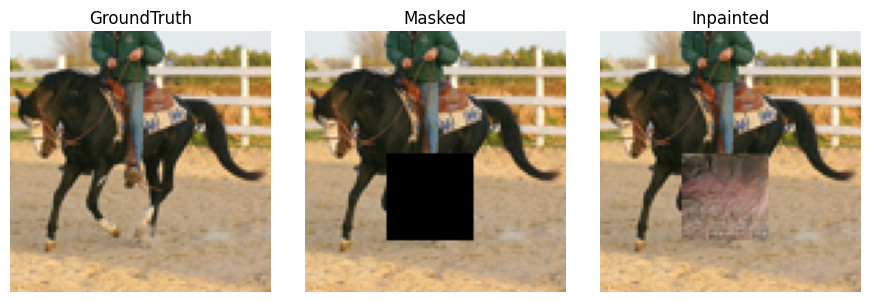

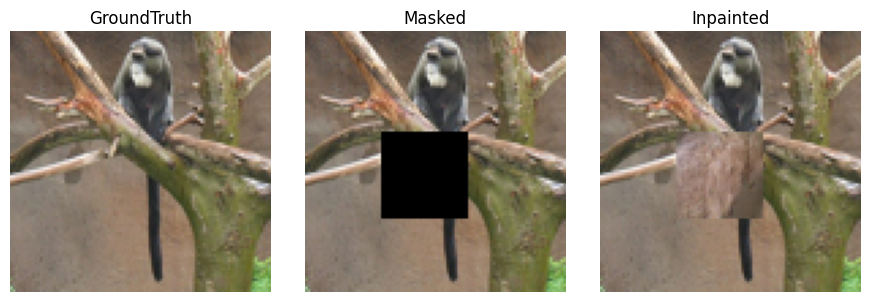

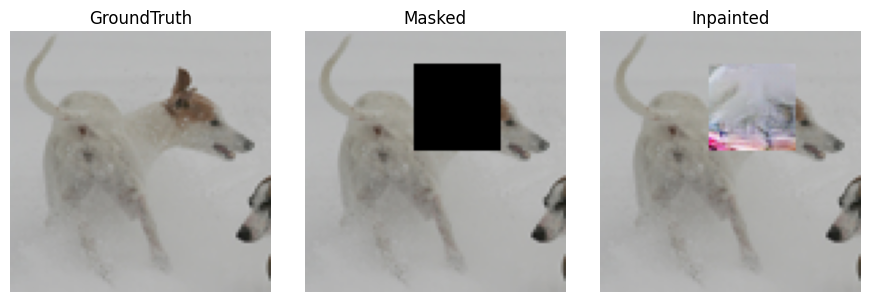

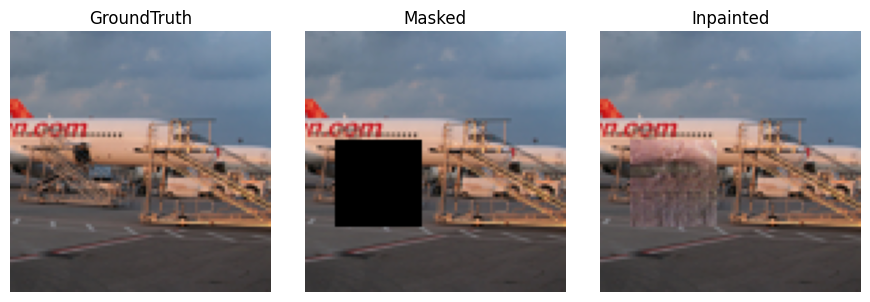

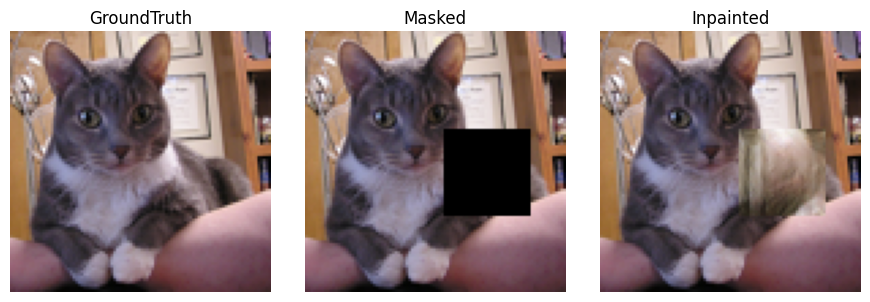

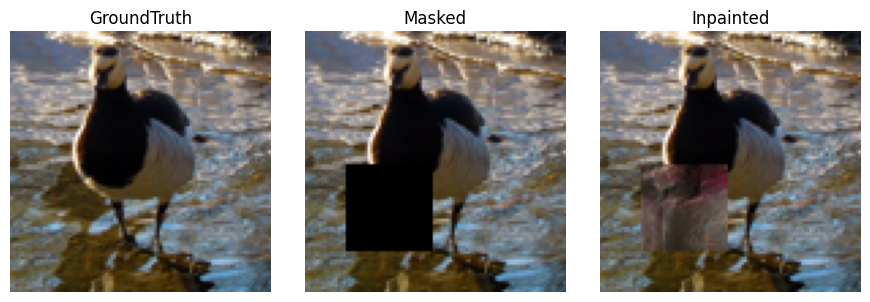

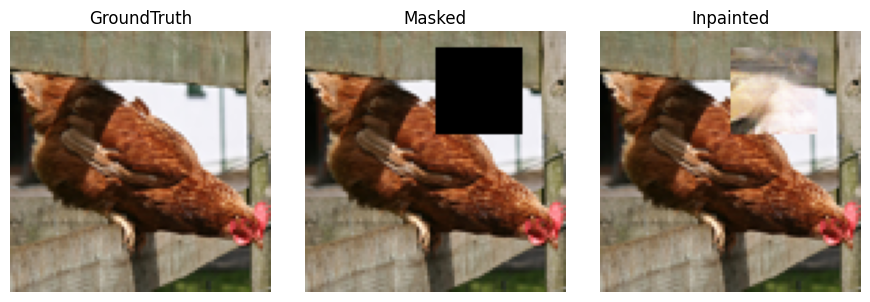

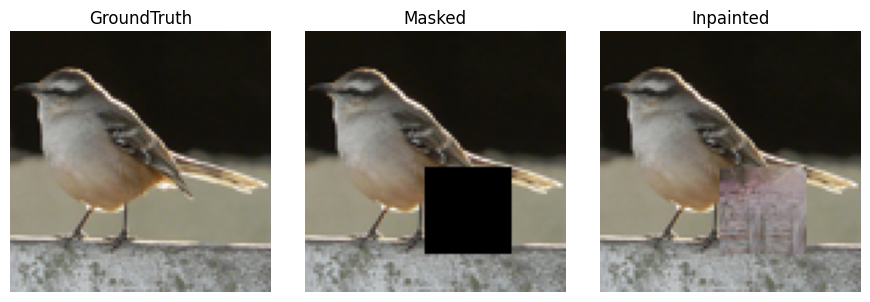

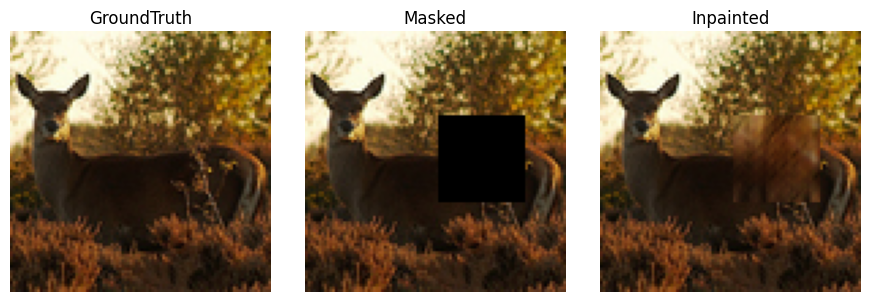

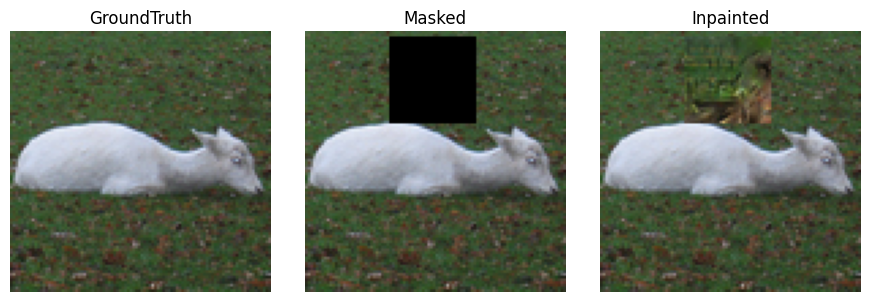

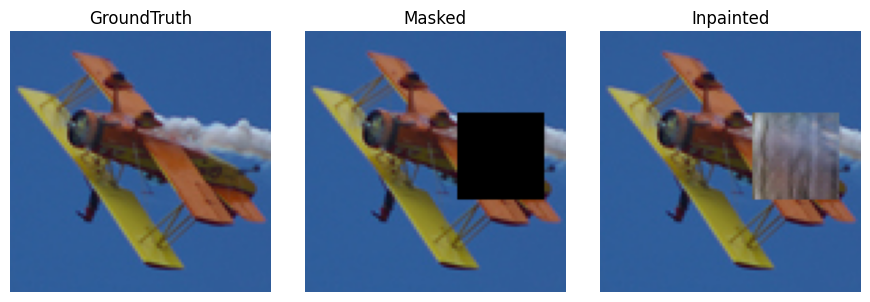

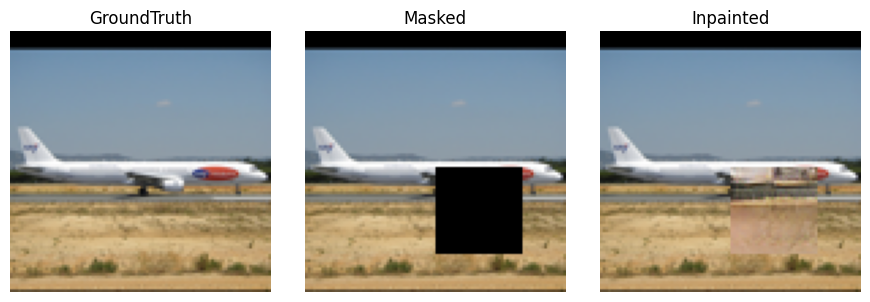

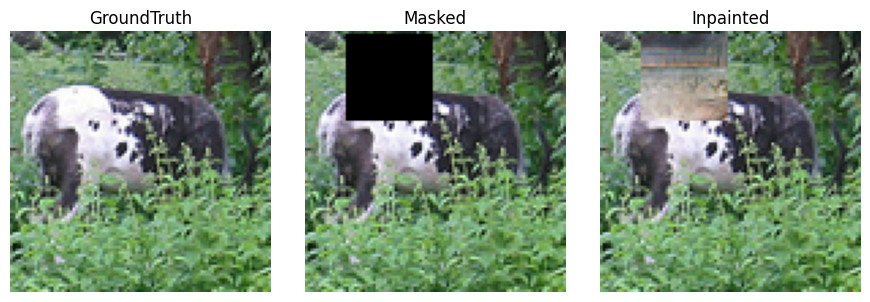

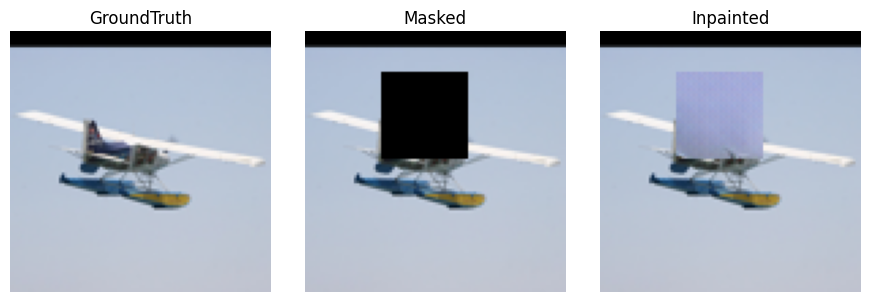

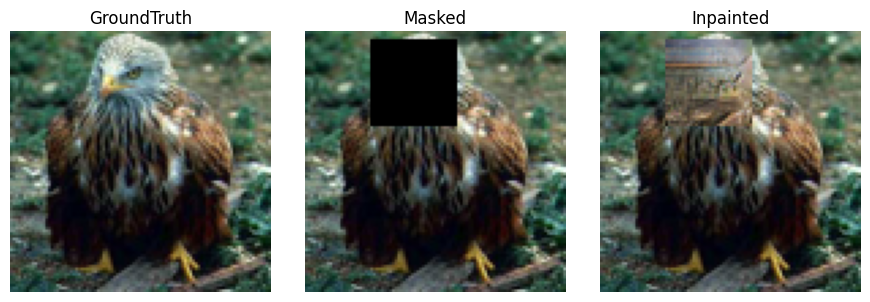

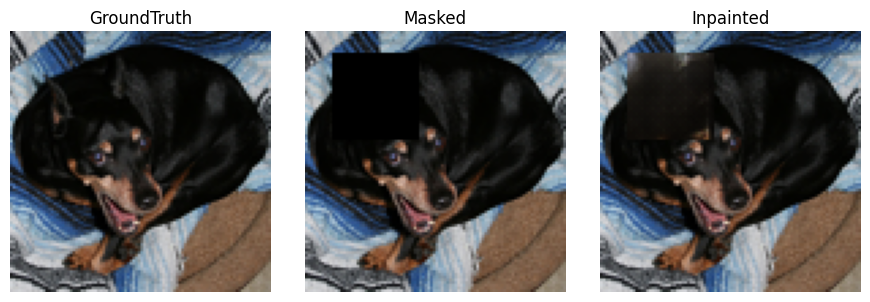

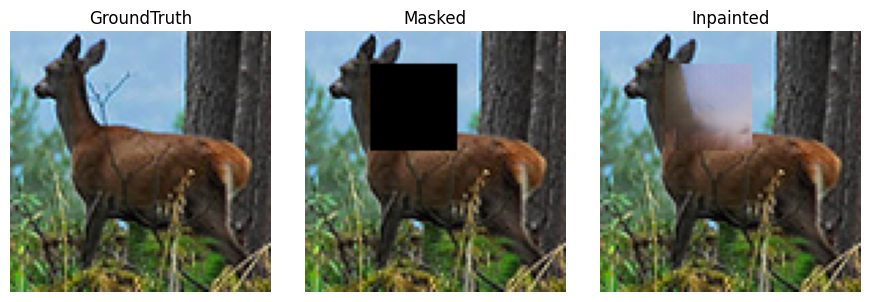

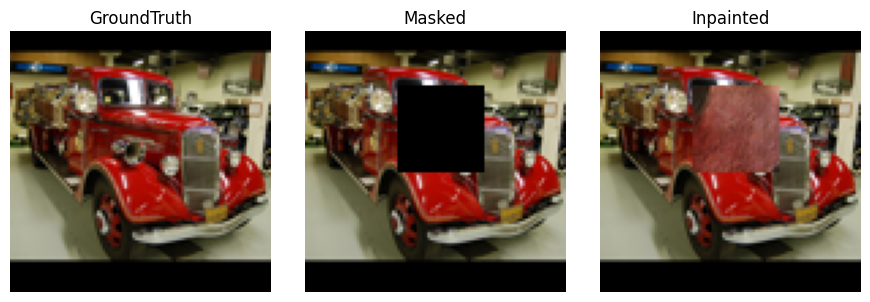

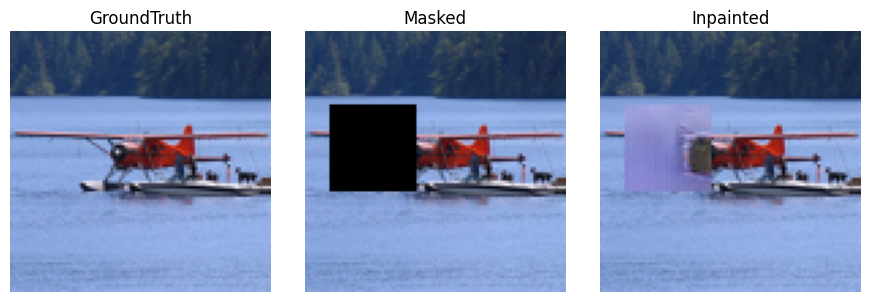

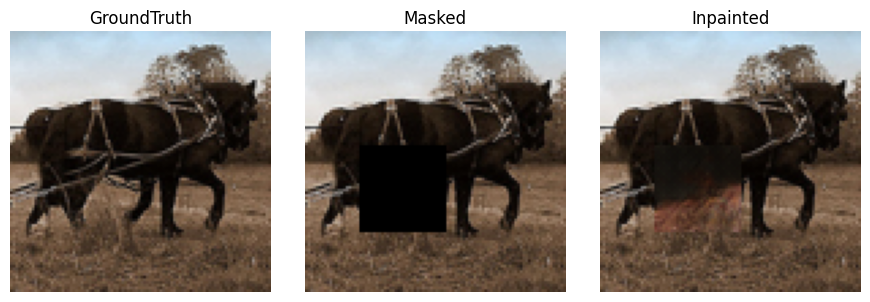

In [14]:
import matplotlib.pyplot as plt
import torch

# Assuming `generator` is your trained generator/inpainting model and `test_loader` is the STL10 test dataset loader
generator.eval()

# Example of showing the ground truth, masked, and predicted inpainted images for 10 images
dataiter = iter(test_loader)  # Use test_loader to visualize unseen data
num_images_to_inpaint = 20
mask_size = 32  # Adjust as per your need

for i in range(num_images_to_inpaint):
    # Get next batch of images and apply mask
    images, _ = next(dataiter)
    images = images.to(device)  # Send images to device (GPU/CPU)
    
    # Apply mask to the first image of the batch
    masked_image, mask_info = mask_image(images[0], mask_size)  # Returns masked image and mask info
    
    plt.figure(figsize=(9, 3))

    # Original ground truth image
    plt.subplot(1, 3, 1)
    plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())  # Convert tensor to (H, W, C) for display
    plt.title("GroundTruth")
    plt.axis('off')
    
    # Masked image
    plt.subplot(1, 3, 2)
    plt.imshow(masked_image.permute(1, 2, 0).cpu().numpy())
    plt.title("Masked")
    plt.axis('off')
    
    # Reconstruct masked image using the generator model
    with torch.no_grad():
        reconstructed = generator(masked_image.unsqueeze(0))  # Add batch dimension for generator input
        reconstructed = reconstructed.squeeze()  # Remove batch dimension after generator processing
    
    # Replace the masked region in the original image with the inpainted (reconstructed) region
    x, y, size = mask_info  # Coordinates and size of the mask
    inpainted_image = images[0].clone()  # Clone the original image to preserve unmasked regions
    inpainted_image[:, y:y + size, x:x + size] = reconstructed[:, y:y + size, x:x + size]  # Replace masked region
    
    # Show the inpainted (reconstructed) image
    plt.subplot(1, 3, 3)
    plt.imshow(inpainted_image.permute(1, 2, 0).cpu().numpy())  # Convert tensor to (H, W, C)
    plt.title("Inpainted")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [21]:
PATH = '/users/pprabaga/ssl-project/inpainting/models/v3/inpainting_model_gen_weights_epoch_100.pth'
path_to_weights = '/users/pprabaga/ssl-project/inpainting/models/v3/inpainting_model_gen_weights_epoch_100.pth'

# Assuming `generator` is already defined as an instance of your InpaintingModel
generator = InpaintingModel().to(device)  # Move model to the same device (GPU/CPU)

# Load the state dictionary
checkpoint = torch.load(path_to_weights)

# Load the weights into the generator
generator.load_state_dict(checkpoint)

backbone = generator.encoder

/tmp/ipykernel_1274670/61596618.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_weights)


In [22]:
for param in backbone.parameters():
    param.requires_grad = True

In [24]:
class ClassificationNet(nn.Module):
    def __init__(self, backbone, num_classes):
        super(ClassificationNet, self).__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        pooled_features = nn.AdaptiveAvgPool2d((1, 1))(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        output = self.classifier(pooled_features)
        return output

classification_model = ClassificationNet(backbone, num_classes=10).to(device)

In [25]:
classification_transform = transforms.Compose([
    # transforms.RandomResizedCrop(96),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # RGB for classification
])

In [26]:
stl10_train = STL10(root='../data', split='train', download=True, transform=classification_transform)
stl10_test = STL10(root='../data', split='test', download=True, transform=classification_transform)

# Fine-tuning: Load training data for classification task
train_loader = DataLoader(stl10_train, batch_size=64, shuffle=True)

# Testing: Load test data for final evaluation
test_loader = DataLoader(stl10_test, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(classification_model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 150
for epoch in range(num_epochs):
    classification_model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = classification_model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    if (epoch + 1) % 10 == 0:
        torch.save(classification_model.state_dict(), f'models/downstream/classification_model_weights_epoch_{epoch+1}.pth')



PATH = 'models/downstream/classification_model_weights_final.pth'
torch.save(classification_model.state_dict(), PATH)

Epoch [1/150], Loss: 1.7390
Epoch [2/150], Loss: 1.2829
Epoch [3/150], Loss: 1.0217
Epoch [4/150], Loss: 0.8241
Epoch [5/150], Loss: 0.6114
Epoch [6/150], Loss: 0.4529
Epoch [7/150], Loss: 0.3168
Epoch [8/150], Loss: 0.2099
Epoch [9/150], Loss: 0.2071
Epoch [10/150], Loss: 0.1516
Epoch [11/150], Loss: 0.1678
Epoch [12/150], Loss: 0.0962
Epoch [13/150], Loss: 0.0767
Epoch [14/150], Loss: 0.0567
Epoch [15/150], Loss: 0.1942
Epoch [16/150], Loss: 0.1127
Epoch [17/150], Loss: 0.0583
Epoch [18/150], Loss: 0.0455
Epoch [19/150], Loss: 0.0179
Epoch [20/150], Loss: 0.0271
Epoch [21/150], Loss: 0.0102
Epoch [22/150], Loss: 0.0249
Epoch [23/150], Loss: 0.0378
Epoch [24/150], Loss: 0.0208
Epoch [25/150], Loss: 0.0236
Epoch [26/150], Loss: 0.2310
Epoch [27/150], Loss: 0.0637
Epoch [28/150], Loss: 0.0825
Epoch [29/150], Loss: 0.0697
Epoch [30/150], Loss: 0.0135
Epoch [31/150], Loss: 0.0054
Epoch [32/150], Loss: 0.0053
Epoch [33/150], Loss: 0.0262
Epoch [34/150], Loss: 0.0364
Epoch [35/150], Loss: 0

In [28]:
# Evaluation
classification_model.eval()  # Set model to evaluation mode
correct = 0
top_5_correct = 0
top_3_correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classification_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        _, predicted_3 = torch.topk(outputs.data, k=3, dim=1)
        correct_3 = predicted_3.eq(labels.unsqueeze(1).expand_as(predicted_3))
        top_3_correct += correct_3.any(dim=1).sum().item()

        _, predicted_5 = torch.topk(outputs.data, k=5, dim=1)
        correct_5 = predicted_5.eq(labels.unsqueeze(1).expand_as(predicted_5))
        top_5_correct += correct_5.any(dim=1).sum().item()



accuracy = 100 * correct / total
top_5 = 100 * top_5_correct / total
top_3 = 100 * top_3_correct / total
print(f'Top-1 Accuracy of the model on the test set: {accuracy:.2f}%')
print(f'Top-5 Accuracy of the model on the test set: {top_5:.2f}%')
print(f'Top-3 Accuracy of the model on the test set: {top_3:.2f}%')

Top-1 Accuracy of the model on the test set: 66.94%
Top-5 Accuracy of the model on the test set: 96.08%
Top-3 Accuracy of the model on the test set: 89.84%
